# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find an optimal office location for a Hotel Tech Startup . Specifically, this report will be targeted to stakeholders interested in choosing an location in **Manhattan**, **New York**.

We will try to detect the location that surrouned with **subway stations**.We are also particularly interested in areas with **chinese restaturant** since most of the employees are asians. We would also prefer locations as close to **Hotels**, assuming that first two conditions are met.

We will use our data science powers to generate a few most promissing neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* number of potential office locations in Manhattan
* number of existing Subway Stations in the neighborhood (particularly **ACE and NWQR**)
* number of and distance to Chinese Restaurants in the neighborhood
* distance of neighborhood from Hotels groups

We decided to use regularly spaced grid of locations, centered around city center, to define our neighborhoods.

Following data sources will be needed to extract/generate the required information:
* Manhattan geo location will be generated by **geopy library**
* number of restaurants and their type and location in every neighborhood will be obtained using **Foursquare API**
* coordinate of Subway Station will be obtained using **[NYC OpenData](https://data.cityofnewyork.us/Transportation/Subway-Stations/arq3-7z49)**

### Office Location

Lets use geopy library to get the latitude and longitude values of **Mahattan, New York**

In [1]:
import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

def get_coordinates(address):
    
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    lat = location.latitude
    lng = location.longitude
    
    return [lat, lng]
    
address = 'Manhattan, NY'
mahattan_geo = get_coordinates(address)
print('The geograpical coordinate of {} are {}.'.format(address,mahattan_geo))

The geograpical coordinate of Manhattan, NY are [40.7900869, -73.9598295].


Let's use get_coordinates function to converted office location address to coordinates

In [2]:
# set up libraries
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [3]:
# Get the office dataframe and clean the data

office_df = pd.read_csv('office.csv')
office_df = office_df.drop(['index'],axis = 1)

In [4]:
# add latitude and longitude columns to the dataframe
office_geo = []
for ad in office_df['address']:
    try: 
        office_geo.append(get_coordinates(ad))
        print(ad + ' Success')
    except:
        print(ad + ' Fail')

office_df = pd.concat([office_df,pd.DataFrame(office_geo,columns=['Latitude','Longitude'])],axis=1)

142 W 57th St New York, NY 10019 Success
12 E 49th St New York, NY 10017 Success
349 5th Ave New York, NY 10016 Success
33 Irving Pl New York, NY 10003 Success
428 Broadway New York, NY 10013 Success
200 Broadway New York, NY 10038 Success


In [5]:
# Rename the column 
office_df.rename(columns= {'address':'Office Address','rent':'Rent'},inplace=True)
office_df

,Office Address,Rent,Latitude,Longitude
0,"142 W 57th St New York, NY 10019","$1,100.00",40.764807,-73.979244
1,"12 E 49th St New York, NY 10017","$1,020.00",40.757368,-73.976870
2,"349 5th Ave New York, NY 10016",$900.00,40.748181,-73.984518
3,"33 Irving Pl New York, NY 10003","$1,190.00",40.735105,-73.988113
4,"428 Broadway New York, NY 10013","$1,000.00",40.719648,-74.001443
5,"200 Broadway New York, NY 10038","$1,080.00",40.710560,-74.009014


Create a **map of Mahattan**, New York using latitude and longitude value and add circle about office location

In [7]:
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

map_newyork= folium.Map(location=mahattan_geo,zoom_start=12)

# add markers to map

for lat,lng,address, price in zip(office_df['Latitude'],office_df['Longitude'],office_df['Office Address'],office_df['Rent']):
    label = '{}, {}'.format(address,price)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)


# show the map
map_newyork

### Subway Location

Get the subway location and show them in the map

In [8]:
# read the csv into dataframe
mta_df = pd.read_csv('subway.csv')

# remove the columns that are irrelvant
mta_df.drop(['URL','NOTES'],axis = 1,inplace=True)

mta_df.head()

,OBJECTID,NAME,the_geom,LINE
0,1,Astor Pl,POINT (-73.99106999861966 40.73005400028978),4-6-6 Express
1,2,Canal St,POINT (-74.00019299927328 40.71880300107709),4-6-6 Express
2,3,50th St,POINT (-73.98384899986625 40.76172799961419),1-2
3,4,Bergen St,POINT (-73.97499915116808 40.68086213682956),2-3-4
4,5,Pennsylvania Ave,POINT (-73.89488591154061 40.66471445143568),3-4


In [9]:
# remove the POINT text
mta_df['the_geom'] = mta_df['the_geom'].str[6:]

# split the column into longitude and latitude
mta_df['longitude'] = mta_df['the_geom'].str.split(' ', expand=True, n=1).iloc[:,0]
mta_df['latitude'] = mta_df['the_geom'].str.split(' ', expand=True, n=1).iloc[:,1]

# delete the 'the_geom' 
mta_df.drop(['the_geom'],axis = 1, inplace=True)

# clean the longitude and latitude
mta_df['longitude'] = mta_df['longitude'].str[1:]
mta_df['latitude'] = mta_df['latitude'].str[:-1]

# change the type 
mta_df['latitude'] = mta_df['latitude'].astype('float')
mta_df['longitude'] = mta_df['longitude'].astype('float')

In [10]:
mta_df.head()

,OBJECTID,NAME,LINE,longitude,latitude
0,1,Astor Pl,4-6-6 Express,-73.991070,40.730054
1,2,Canal St,4-6-6 Express,-74.000193,40.718803
2,3,50th St,1-2,-73.983849,40.761728
3,4,Bergen St,2-3-4,-73.974999,40.680862
4,5,Pennsylvania Ave,3-4,-73.894886,40.664714


Since the client only cares about **ace** and **nqwr** station in manhattan, we will remove other data

In [11]:
# remove the station that is not in Manhattan
top_left = [40.806470, -73.973205]
bottom_left = [40.709729, -74.035690]
bottom_right = [40.696715, -73.992431]
top_right = [40.781518, -73.934066]

low_lat = bottom_right[0]
high_lat = top_left[0]       
low_lon = top_right[1]
high_lon = bottom_left[1]

mta_df = mta_df.loc[
    (mta_df["latitude"] < high_lat) & 
    (mta_df["latitude"] > low_lat) &
    (mta_df["longitude"] > high_lon) &
    (mta_df["longitude"] < low_lon)
]

In [12]:
# how many lines we have
mta_df['LINE'].unique()

array(['4-6-6 Express', '1-2', 'A-B-C', 'J-M-Z', '4-5-6-6 Express',
       'B-D-F-M', 'E-M', 'G', 'L', 'J-M', 'N-Q-R-W', 'S', '7-7 Express',
       '7-7 Express-N-W', '1-2-3', '1', '2-3', 'A-C-E', 'E-M-R', 'F',
       'B-D-E', 'F-Q', 'A-B-C-D', 'N-R-W', 'A-C', 'F-M', 'E', 'J-Z',
       'R-W', '4-5', 'B-D', 'N-Q', 'Q'], dtype=object)

In [13]:
# Remove lines that are not ACE and NQRW
ace_list = ['A-B-C','E-M','A-C-E','E-M-R','A-B-C-D','A-C','E']
nqrw_list = ['N-Q-R-W','7-7 Express-N-W','N-R-W','F-Q','R-W','N-Q','Q']
mta_ace = mta_df[mta_df['LINE'].isin(ace_list)]
mta_nqrw = mta_df[mta_df['LINE'].isin(nqrw_list)]

Let's map the station into the map with blue stands for ace and yellow stands for nqrw

In [14]:
# add ace markers to map

for lat,lng,name, line in zip(mta_ace['latitude'],mta_ace['longitude'],mta_ace['NAME'],mta_ace['LINE']):
    label = '{}, {}'.format(name,line)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)

# add nqrw markers to map

for lat,lng,name, line in zip(mta_nqrw['latitude'],mta_nqrw['longitude'],mta_nqrw['NAME'],mta_nqrw['LINE']):
    label = '{}, {}'.format(name,line)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=2,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)

# show map
map_newyork

### FOURSQUARE

Define Foursquare Credentials, Version and the category id for **Hotel** and **Chinese Resturant**.

In [15]:
CLIENT_ID = 'THW4T43GANDRLSNMXNCEK1ZGIBT0T2ONW3UXXXPVFBR2LS2Y' # your Foursquare ID
CLIENT_SECRET = 'X3IFLAKKQQCOKA40VJVJS31FPHHAGP5O150C0WUENFZ1UPNF' # your Foursquare Secret
VERSION = '20180605'
CHINESE_RESTURANT = '4bf58dd8d48988d145941735'
HOTEL = '4bf58dd8d48988d1fa931735'
LIMIT = 200
radius = 1000
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: THW4T43GANDRLSNMXNCEK1ZGIBT0T2ONW3UXXXPVFBR2LS2Y
CLIENT_SECRET:X3IFLAKKQQCOKA40VJVJS31FPHHAGP5O150C0WUENFZ1UPNF


Let's create a function to repeat the same process to the nearby venues in Manhattan for different categories.

In [30]:
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe


def getNearbyVenue(category,names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            category,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        # make the GET request
        results = requests.get(url).json()["response"]["venues"]
        # return only  relevant information for each nearby venue
        venues_list.append([(
            name,
            lat,
            lng,
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],
            v['location']['distance'],
            v['categories'][0]['name']
            ) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Office Address', 
                  'Office Latitude', 
                  'Office Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Distance' ,          
                  'Venue Category']
    return (nearby_venues)

Run the above function on each office and create a new dataframe called manhattan_restaurant.

In [31]:
manhattan_restaurant = getNearbyVenue(category=CHINESE_RESTURANT,
                                 names=office_df['Office Address'],
                                 latitudes=office_df['Latitude'],
                                 longitudes=office_df['Longitude']
                                  )

142 W 57th St New York, NY 10019
12 E 49th St New York, NY 10017
349 5th Ave New York, NY 10016
33 Irving Pl New York, NY 10003
428 Broadway New York, NY 10013
200 Broadway New York, NY 10038


Take a look at the dataframe

In [32]:
manhattan_restaurant.head()

,Office Address,Office Latitude,Office Longitude,Venue,Venue Latitude,Venue Longitude,Venue Distance,Venue Category
0,"142 W 57th St New York, NY 10019",40.764807,-73.979244,Tang Pavilion,40.762828,-73.977295,274,Chinese Restaurant
1,"142 W 57th St New York, NY 10019",40.764807,-73.979244,Hunan House Manhattan,40.763152,-73.976516,294,Hunan Restaurant
2,"142 W 57th St New York, NY 10019",40.764807,-73.979244,Tian-Jin Chinese Restaurant,40.763492,-73.982684,324,Chinese Restaurant
3,"142 W 57th St New York, NY 10019",40.764807,-73.979244,Joe's Shanghai 鹿鸣春,40.763136,-73.975857,340,Chinese Restaurant
4,"142 W 57th St New York, NY 10019",40.764807,-73.979244,Dim Sum Palace,40.762509,-73.977047,315,Dim Sum Restaurant


Let's check how many venues were returned for each neighborhood

In [34]:
manhattan_restaurant.groupby('Office Address').count()

,Office Latitude,Office Longitude,Venue,Venue Latitude,Venue Longitude,Venue Distance,Venue Category
Office Address,,,,,,,
"12 E 49th St New York, NY 10017",29,29,29,29,29,29,29
"142 W 57th St New York, NY 10019",18,18,18,18,18,18,18
"200 Broadway New York, NY 10038",25,25,25,25,25,25,25
"33 Irving Pl New York, NY 10003",46,46,46,46,46,46,46
"349 5th Ave New York, NY 10016",37,37,37,37,37,37,37
"428 Broadway New York, NY 10013",50,50,50,50,50,50,50


Let's find out how many unique categories can be curated from all the returned venues

In [22]:
print('There are {} uniques chinese resturants.'.format(len(manhattan_restaurant['Venue Category'].unique())))

There are 18 uniques chinese resturants.


In [35]:
manhattan_hotels = getNearbyVenue(category=HOTEL,
                                 names=office_df['Office Address'],
                                 latitudes=office_df['Latitude'],
                                 longitudes=office_df['Longitude']
                                  )

142 W 57th St New York, NY 10019
12 E 49th St New York, NY 10017
349 5th Ave New York, NY 10016
33 Irving Pl New York, NY 10003
428 Broadway New York, NY 10013
200 Broadway New York, NY 10038


Let's check how many venues were returned for each neighborhood

In [36]:
manhattan_hotels.groupby('Office Address').count()

,Office Latitude,Office Longitude,Venue,Venue Latitude,Venue Longitude,Venue Distance,Venue Category
Office Address,,,,,,,
"12 E 49th St New York, NY 10017",50,50,50,50,50,50,50
"142 W 57th St New York, NY 10019",50,50,50,50,50,50,50
"200 Broadway New York, NY 10038",45,45,45,45,45,45,45
"33 Irving Pl New York, NY 10003",24,24,24,24,24,24,24
"349 5th Ave New York, NY 10016",50,50,50,50,50,50,50
"428 Broadway New York, NY 10013",42,42,42,42,42,42,42


Let's find out how many unique categories can be curated from all the returned venues

In [70]:
print('There are {} uniques hotels.'.format(len(manhattan_hotels['Venue Category'].unique())))

There are 14 uniques hotels.


Now we have collected nearby chinese resturants and hotels around each office location. We also have all the Blue and Yellow subway line in the Manhattan

This concludes the data gathering phase - we're now ready to use this data for analysis to produce the report on optimal locations for a new office!

## Methodology <a name="methodology"></a>

In this project we will direct our efforts on detecting office spaces of Manhattan that have blue and yellow line and Asian resturants. We will limit our analysis to chinese resturants around each office location.

In first step we have collected the required **data: location and chinese restaurants of each office space.** We have also **identified Blue and Yellow subway line.**

Second step in our analysis will be calculation and exploration of **'restaurant density'** across different office locations of Manhattan - we will use **heatmaps** to identify a few promising areas close to center with low number of restaurants in general and focus our attention on those areas.

In third and final step we will focus on most promising areas and within those create **clusters of locations that meet some basic requirements** established in discussion with stakeholders: we will take into consideration locations that **near the subway stations**, and we want **locations with chinese restaurants nearby**. We will present map of all such locations but also create clusters (using **k-means clustering**) of those locations to identify general zones / neighborhoods / addresses which should be a starting point for final 'street level' exploration and search for optimal venue location by stakeholders.

## Analysis <a name="analysis"></a>

Let's perform some basic explanatory data analysis and derive some additional info from our raw data. First let's count the number of restaurants in every area candidate:

In [38]:
# Get the number of the resturants, hotels and average distance for both.
office_stat = manhattan_restaurant.groupby('Office Address')['Venue Distance'].agg(['mean','count'])

office_df =  pd.merge(office_df, office_stat, on="Office Address")

# Rename the columns
office_df.rename(columns={'mean':'Average Distance','count':'Num of Resturants'},inplace=True)

In [40]:
# Get the number of the resturants, hotels and average distance for both.
office_hotel = manhattan_hotels.groupby('Office Address')['Venue Distance'].agg(['mean','count'])

office_df =  pd.merge(office_df, office_hotel, on="Office Address")

# Rename the columns
office_df.rename(columns={'mean':'Average Distance to Hotel','count':'Num of Hotes'},inplace=True)

Let's calculate the **distance** to **ACE and NQRW** subway lines for each office location

In [41]:
office_geo = office_df[['Latitude','Longitude']].values.tolist()

In [42]:
import geopy.distance
# Calculate ace disntance
ace_distance = [[]]
for lat,lng in zip(mta_ace['latitude'],mta_ace['longitude']):
    lat_lng=[lat,lng]
    l_dis=[]
    for item in office_geo:
       l_dis.append(geopy.distance.geodesic(lat_lng, item).meters)
    ace_distance.append(l_dis)

# Calculate nqrw disntance
nqrw_distance = [[]]
for lat,lng in zip(mta_nqrw['latitude'],mta_nqrw['longitude']):
    lat_lng=[lat,lng]
    l_dis=[]
    for item in office_geo:
       l_dis.append(geopy.distance.geodesic(lat_lng, item).meters)
    nqrw_distance.append(l_dis)

# Remove the first empty item in the list
ace_distance = ace_distance[1:]
nqrw_distance = nqrw_distance[1:]


In [43]:
# Convert the list into dataframe
ace_df = pd.DataFrame(ace_distance,columns=['142','12','349','33','428','200'])
nqrw_df = pd.DataFrame(nqrw_distance,columns=['142','12','349','33','428','200'])

# Assian the minimum value and combined distance to the office dataframe
office_df['Min Distance to ACE'] = ace_df.min().values
office_df['Min Distance to NQRW'] = nqrw_df.min().values
office_df['Combined Distance']=office_df['Min Distance to ACE']+office_df['Min Distance to NQRW']

In [67]:
office_df.sort_values(by='Combined Distance')

,Office Address,Rent,Latitude,Longitude,Average Distance,Num of Resturants,Average Distance to Hotel,Num of Hotes,Min Distance to ACE,Min Distance to NQRW,Combined Distance
5,"200 Broadway New York, NY 10038","$1,080.00",40.710560,-74.009014,425.520000,25,363.866667,45,125.559699,179.057566,304.617266
4,"428 Broadway New York, NY 10013","$1,000.00",40.719648,-74.001443,432.480000,50,386.619048,42,345.482333,38.196249,383.678582
0,"142 W 57th St New York, NY 10019","$1,100.00",40.764807,-73.979244,356.500000,18,298.040000,50,432.855193,128.300547,561.155740
1,"12 E 49th St New York, NY 10017","$1,020.00",40.757368,-73.976870,379.724138,29,431.720000,50,331.546702,676.187634,1007.734335
2,"349 5th Ave New York, NY 10016",$900.00,40.748181,-73.984518,325.702703,37,384.820000,50,877.125813,331.292994,1208.418807
3,"33 Irving Pl New York, NY 10003","$1,190.00",40.735105,-73.988113,447.826087,46,388.083333,24,1090.128918,221.886144,1312.015062


We now can see the average distance and numbers of **chinese resturants** and **hotels** and also the minimum and combined distance to two **subway lines**.

Offices on **200 Broadway,428 Broadway and 142 W 57th St ** have a close distance to both subway lines

Let's plot the **heatmap** about the **chinese resturants** we have and add the the **office location** as markers in the map.

In [45]:
resturant_latlng= manhattan_restaurant[['Venue Latitude','Venue Longitude']].values.tolist()

In [46]:
# Get the Coordinates of Union Square
Union_Square = get_coordinates('Union Square New York, NY 10003')

In [48]:
from folium import plugins
from folium.plugins import HeatMap

# create a map obejcttive
map_Manhattan = folium.Map(location=mahattan_geo, zoom_start=12)
folium.TileLayer('cartodbpositron').add_to(map_Manhattan) #cartodbpositron cartodbdark_matter

# add heat map and circle of different distance
HeatMap(resturant_latlng).add_to(map_Manhattan)
folium.Marker(Union_Square).add_to(map_Manhattan)
folium.Circle(Union_Square, radius=1500, fill=False, color='white').add_to(map_Manhattan)
folium.Circle(Union_Square, radius=2500, fill=False, color='white').add_to(map_Manhattan)
folium.Circle(Union_Square, radius=3500, fill=False, color='white').add_to(map_Manhattan)

# add office markers to map
for lat,lng,address, price in zip(office_df['Latitude'],office_df['Longitude'],office_df['Office Address'],office_df['Rent']):
    label = '{}, {}'.format(address,price)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        color='white',
        fill=True,
        fill_color='white',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Manhattan)
# show the map
map_Manhattan

We can see from the map that the almost all the offices are in the hot zone but only offices in **349 5th Ave New York, 33 Irving Pl New York** are in the midle of the zone

Lets **cluster** all the resturants and plot the center of the cluster which indicates the best location based on the resturant location

First we have to determin the best number of clusters using the **Elbow method**.

In [50]:
restaurant_cluster = manhattan_restaurant.loc[:,['Venue Latitude','Venue Longitude']]

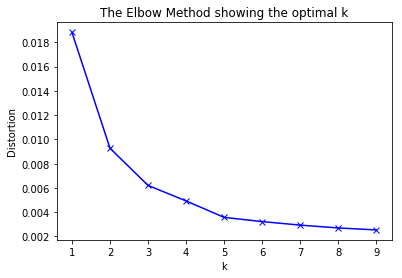

In [52]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt


distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(restaurant_cluster)
    kmeanModel.fit(restaurant_cluster)
    distortions.append(sum(np.min(cdist(restaurant_cluster, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / restaurant_cluster.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

When K increases, the centroids are closer to the clusters centroids.

The improvements will decline, at some point rapidly, creating the elbow shape.

That point is the optimal value for K. In the image above, **K is range from 3 to 5**.

In [53]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(restaurant_cluster)

# Get the centers of clusters
cluster_centers = [cc for cc in kmeans.cluster_centers_]

In [54]:

map_Manhattan = folium.Map(location=mahattan_geo, zoom_start=12)
folium.TileLayer('cartodbpositron').add_to(map_Manhattan) #cartodbpositron cartodbdark_matter
HeatMap(resturant_latlng).add_to(map_Manhattan)

# add cluster centers in the map
for lat, lng in cluster_centers:
    folium.CircleMarker(
        [lat, lng], 
        radius=5, 
        color='black', 
        fill=True, 
        fill_opacity=1
        ).add_to(map_Manhattan) 

# add office locations in the map
for lat,lng,address, price in zip(office_df['Latitude'],office_df['Longitude'],office_df['Office Address'],office_df['Rent']):
    label = '{}, {}'.format(address,price)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        color='white',
        fill=True,
        fill_opacity=1,
        parse_html=False).add_to(map_Manhattan)
map_Manhattan

In [55]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(restaurant_cluster)

# Get the centers of clusters
cluster_centers = [cc for cc in kmeans.cluster_centers_]

In [56]:

map_Manhattan = folium.Map(location=mahattan_geo, zoom_start=12)
folium.TileLayer('cartodbpositron').add_to(map_Manhattan) #cartodbpositron cartodbdark_matter
HeatMap(resturant_latlng).add_to(map_Manhattan)

# add cluster centers in the map
for lat, lng in cluster_centers:
    folium.CircleMarker(
        [lat, lng], 
        radius=5, 
        color='black', 
        fill=True, 
        fill_opacity=1
        ).add_to(map_Manhattan) 

# add office locations in the map
for lat,lng,address, price in zip(office_df['Latitude'],office_df['Longitude'],office_df['Office Address'],office_df['Rent']):
    label = '{}, {}'.format(address,price)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        color='white',
        fill=True,
        fill_opacity=1,
        parse_html=False).add_to(map_Manhattan)
map_Manhattan

In [68]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(restaurant_cluster)

# Get the centers of clusters
cluster_centers = [cc for cc in kmeans.cluster_centers_]

In [58]:

map_Manhattan = folium.Map(location=mahattan_geo, zoom_start=12)
folium.TileLayer('cartodbpositron').add_to(map_Manhattan) #cartodbpositron cartodbdark_matter
HeatMap(resturant_latlng).add_to(map_Manhattan)

# add cluster centers in the map
for lat, lng in cluster_centers:
    folium.CircleMarker(
        [lat, lng], 
        radius=5, 
        color='black', 
        fill=True, 
        fill_opacity=1
        ).add_to(map_Manhattan) 

# add office locations in the map
for lat,lng,address, price in zip(office_df['Latitude'],office_df['Longitude'],office_df['Office Address'],office_df['Rent']):
    label = '{}, {}'.format(address,price)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        color='white',
        fill=True,
        fill_opacity=1,
        parse_html=False).add_to(map_Manhattan)
map_Manhattan

Lets show the results without the heat map

In [69]:

map_Manhattan = folium.Map(location=mahattan_geo, zoom_start=12)

# add cluster centers in the map
for lat, lng in cluster_centers:
    folium.CircleMarker(
        [lat, lng], 
        radius=5, 
        color='blue', 
        fill=True, 
        fill_opacity=1
        ).add_to(map_Manhattan) 

# add office locations in the map
for lat,lng,address, price in zip(office_df['Latitude'],office_df['Longitude'],office_df['Office Address'],office_df['Rent']):
    label = '{}, {}'.format(address,price)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_opacity=1,
        parse_html=False).add_to(map_Manhattan)
map_Manhattan

Blue represents the cluster center and green represents the office locations. We can see from the map that ofice **349 5th Ave, 33 Irving Pl and 200 Broadway** have a relativly perfect match. 

Let's repeat the steps for nearby **Hotels**.

In [60]:
hotel_cluster = manhattan_hotels.loc[:,['Venue Latitude','Venue Longitude']]

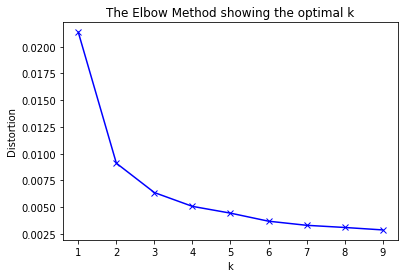

In [61]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(hotel_cluster)
    kmeanModel.fit(hotel_cluster)
    distortions.append(sum(np.min(cdist(hotel_cluster, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / hotel_cluster.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In the image above, **K is 2**.

In [62]:
# set number of clusters
kclusters = 2

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(hotel_cluster)

# Get the centers of clusters
cluster_centers = [cc for cc in kmeans.cluster_centers_]

In [63]:

map_Manhattan = folium.Map(location=mahattan_geo, zoom_start=12)
folium.TileLayer('cartodbpositron').add_to(map_Manhattan) #cartodbpositron cartodbdark_matter
HeatMap(resturant_latlng).add_to(map_Manhattan)

# add cluster centers in the map
for lat, lng in cluster_centers:
    folium.CircleMarker(
        [lat, lng], 
        radius=5, 
        color='black', 
        fill=True, 
        fill_opacity=1
        ).add_to(map_Manhattan) 

# add office locations in the map
for lat,lng,address, price in zip(office_df['Latitude'],office_df['Longitude'],office_df['Office Address'],office_df['Rent']):
    label = '{}, {}'.format(address,price)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        color='white',
        fill=True,
        fill_opacity=1,
        parse_html=False).add_to(map_Manhattan)
map_Manhattan

We can see from the heat map that there are two large hotel clusters and office in **349 5th Ave, 12 E 49th St, 428 Broadway and 200 Broadway** are relativly close to the location.

Let's see the map without the heat map

In [64]:
map_Manhattan = folium.Map(location=mahattan_geo, zoom_start=12)

# add cluster centers in the map
for lat, lng in cluster_centers:
    folium.CircleMarker(
        [lat, lng], 
        radius=5, 
        color='blue', 
        fill=True, 
        fill_opacity=1
        ).add_to(map_Manhattan) 

# add office locations in the map
for lat,lng,address, price in zip(office_df['Latitude'],office_df['Longitude'],office_df['Office Address'],office_df['Rent']):
    label = '{}, {}'.format(address,price)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_opacity=1,
        parse_html=False).add_to(map_Manhattan)
map_Manhattan

## Results and Discussion <a name="results"></a>

The analysis shows the result that there are number of Chinese Resturants and Hotels near all six office locations and distance to both ACE and NQWR subway line varies.

From the heatmap of **Chinese Restaurant**, we can see that office on **349 5th Ave, 33 Irving Pl and 200 Broadway** have a relativly perfect location. 

From the distance of **Subway Lines**, we can see that Offices on **200 Broadway,428 Broadway and 142 W 57th St** have a close distance to both subway lines.

From the heatmap of **Hotels**, we can see that office on **349 5th Ave, 12 E 49th St, 428 Broadway and 200 Broadway** are relativly close to the cluster center.

## Conclusion <a name="conclusion"></a>

Based on the priority of the requirments from stakeholder, office on **200 Broadway New York, NY 10038** with a monthly rent of 1,080 dollars would be a great location for this startup company since it has the best location for chinese restaurant, and relativly close distance to the required subway stations and in the middle of two hotel groups.

The second recommended location would be **349 5th Ave New York, NY 10016** with a montly rent of 900 dollars and closer locaion to the midtown.

Final decission on optimal office location will be made by stakeholders based on specific characteristics of neighborhoods and locations in additional factors.
